# Hypothesis Testing on ProteinGym 166 Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os

import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder
from src.plotting import *
from src.amino_acid_groups import AA_GROUPS
from src.constants import GEMME_ALPHABET
from src.utils import *

## Load Scores

In [4]:
# load all the vespag scores for the proteingym_166 dataset 
vespag_folder = '/mnt/f/nicole/proteingym_166_vespag/'
vespag_scores = load_vespag_scores_from_folder(vespag_folder)   
vespag_scores['wildtype'] = vespag_scores['residue'].str[0]
vespag_scores['mutant'] = vespag_scores['mutation'].str[-1]
# normalise the vespag score into [0,1]
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
vespag_scores['mutation_effect'] = (vespag_scores['mutation_effect'] - vespag_scores['mutation_effect'].min()) / (vespag_scores['mutation_effect'].max() - vespag_scores['mutation_effect'].min())
vespag_scores['mutation_type'] = vespag_scores['wildtype'] + '-' + vespag_scores['mutant']
vespag_scores.head()

Loading VespaG scores:   0%|          | 0/166 [00:00<?, ?file/s]

Loading VespaG scores: 100%|██████████| 166/166 [00:05<00:00, 32.47file/s]


,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type
0,M1,M1A,-2.963631,A0A192B1T2_9HIV1,M,A,0.392495,M-A
1,M1,M1Y,-2.748039,A0A192B1T2_9HIV1,M,Y,0.370785,M-Y
2,M1,M1W,-2.755614,A0A192B1T2_9HIV1,M,W,0.371548,M-W
3,M1,M1V,-2.000395,A0A192B1T2_9HIV1,M,V,0.295498,M-V
4,M1,M1T,-2.908687,A0A192B1T2_9HIV1,M,T,0.386962,M-T


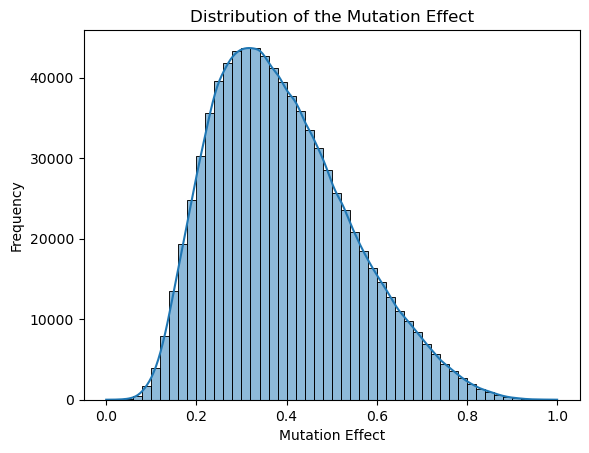

In [5]:
# check the distributiuon of the mutation effect 
sns.histplot(vespag_scores['mutation_effect'], bins=50, kde=True)
plt.title('Distribution of the Mutation Effect')
plt.xlabel('Mutation Effect')
plt.ylabel('Frequency')
plt.show()

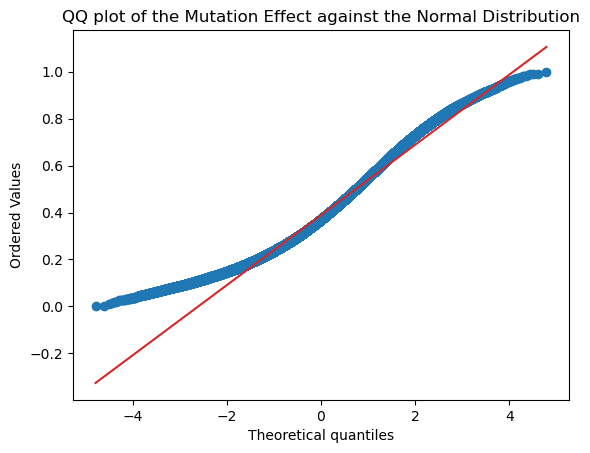

In [6]:
from scipy import stats

# Q-Q plot against the normal distribution
fig, ax = plt.subplots()
res = stats.probplot(vespag_scores['mutation_effect'], dist="norm", plot=ax)

ax.get_lines()[0].set_color("tab:blue")
ax.get_lines()[1].set_color("tab:red")

ax.set_title('QQ plot of the Mutation Effect against the Normal Distribution')
plt.show()


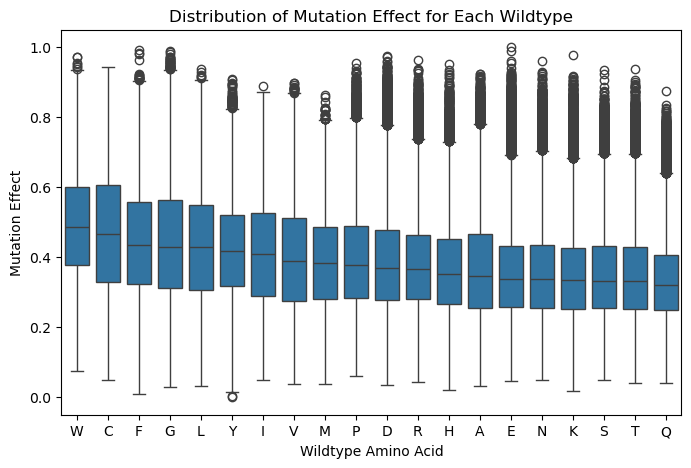

In [7]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(8,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('wildtype')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='wildtype', y='mutation_effect', order=order)
plt.title('Distribution of Mutation Effect for Each Wildtype')
plt.xlabel('Wildtype Amino Acid')
plt.ylabel('Mutation Effect')
plt.show()

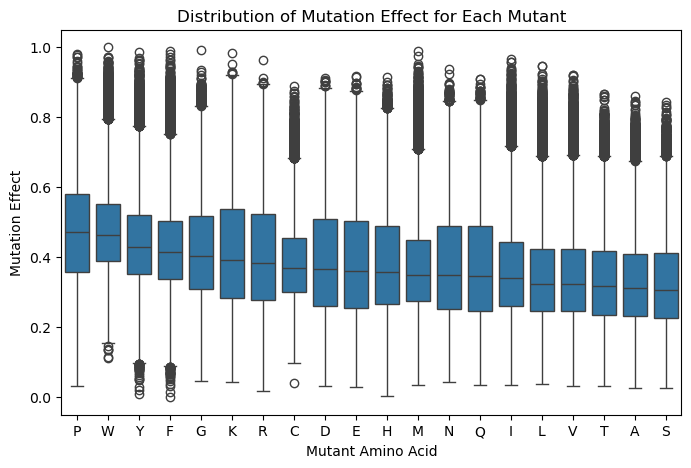

In [8]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(8,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('mutant')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='mutant', y='mutation_effect', order=order)
plt.title('Distribution of Mutation Effect for Each Mutant')
plt.xlabel('Mutant Amino Acid')
plt.ylabel('Mutation Effect')
plt.show()

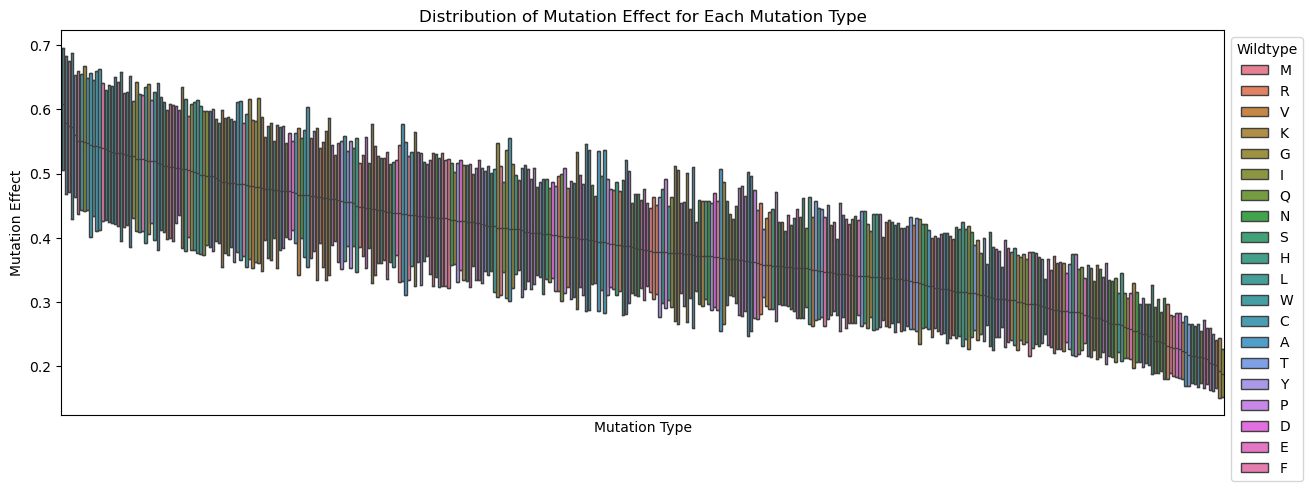

In [9]:
# show the distribution of the mutation effect for each amino acid
plt.figure(figsize=(15,5))
# order by the median of the mutation effect
order = vespag_scores.groupby('mutation_type')['mutation_effect'].median().sort_values(ascending=False).index
sns.boxplot(data=vespag_scores, x='mutation_type', y='mutation_effect', order=order, hue='wildtype', showfliers=False, whis=0)
plt.title('Distribution of Mutation Effect for Each Mutation Type')
plt.xlabel('Mutation Type')
plt.xticks([])
plt.ylabel('Mutation Effect')
plt.legend(title="Wildtype", bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Does the wildtype influence the VespaG scores more than the mutation does?

### Kruskal Wallis Test 

- Non-parametric extension of ANOVA 
- H0: The median of the mutation effect does not depend on the wildtype / The meidan of the mutation effect is the same for all wildtype amino acids. 

In [10]:
from scipy.stats import kruskal 
from scipy.stats import chi2 

def custom_kruskal_wallis_test(df, alpha, feature, target):
    # get the unique values of the feature
    unique_values = df[feature].unique()
    # group the target based on the unique values of the feature
    groups = [df[df[feature] == value][target] for value in unique_values]
    # perform the kruskal wallis test
    stat, p = kruskal(*groups)
    degrees_of_freedom = len(groups) - 1
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)
    significance = p < alpha
    return stat, p, critical_value, degrees_of_freedom, significance

In [11]:
alpha = 0.001

stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype vs. Mutation Effect: p={p}, stat={stat}, critical_value={critical_value}, degrees_of_freedom={degrees_of_freedom}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant vs. Mutation Effect: p={p}, stat={stat}, critical_value={critical_value}, degrees_of_freedom={degrees_of_freedom}, significance={significance}')

Kruskal-Wallis Test for the Wildype vs. Mutation Effect: p=0.0, stat=48645.05142081142, critical_value=43.82019596451753, degrees_of_freedom=19, significance=True
Kruskal-Wallis Test for the Mutant vs. Mutation Effect: p=0.0, stat=71350.82101224478, critical_value=43.82019596451753, degrees_of_freedom=19, significance=True


### Dunn's Test 

- Pairwise test after Kruskal Wallis Test 
- H0: The median of the mutation effect does not depend on the wildtype / The meidan of the mutation effect is the same for all wildtype amino acids. 

In [12]:
from statsmodels.stats.multitest import multipletests

def custom_dunns_test(df, alpha, feature, target):
    ''' We have to prevent MemoryError that results from the internal implementation of the posthoc_dunn function
    
    Computes only a single Kruskal-Wallis test at a time instead of constructing an NxN matrix.
    Bonferroni correction is applied to the p-values.
    '''
    # we have to split the dataset into different groups for performance reasons 
    groups = df[feature].unique()
    posthoc_results = []
    for group1 in groups:
        for group2 in groups:
            if group1 < group2:  # Avoid redundant comparisons
                group1_data = df[df[feature] == group1][target].values
                group2_data = df[df[feature] == group2][target].values
                
                # Only run test if both groups have enough data
                _, p_value = kruskal(group1_data, group2_data)
                
                posthoc_results.append({
                    'group_1': group1,
                    'group_2': group2,
                    'p_value': p_value
                })
    
    # correct for multiple comparisons using bonferroni
    posthoc_results = pd.DataFrame(posthoc_results)
    _, p_adjusted, _, _ = multipletests(posthoc_results['p_value'], method='bonferroni')
    posthoc_results['p_adjusted'] = p_adjusted
    posthoc_results['significant'] = posthoc_results['p_adjusted'] < alpha
    return posthoc_results

In [13]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
8,M,P,0.012420,1.000000,False
21,K,S,0.026550,1.000000,False
24,K,T,0.525569,1.000000,False
62,N,S,0.001446,0.274693,False
69,S,T,0.003826,0.726941,False
122,A,H,0.010982,1.000000,False
136,P,V,0.000143,0.027100,False
143,D,R,0.010718,1.000000,False
166,E,N,0.683511,1.000000,False
167,E,S,0.000035,0.006582,False


In [14]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
36,P,W,0.000249,0.047370,False
47,N,Q,0.068648,1.000000,False
68,L,V,0.461824,1.000000,False
87,D,E,0.000016,0.003002,False
89,D,H,0.018730,1.000000,False
105,E,H,0.023407,1.000000,False
188,M,N,0.002006,0.381095,False


### Fligner-Killeen Test

- For non normal data 
- H0: The variance of the groups is the same. 

In [15]:
from scipy.stats import fligner

def custon_fligner_killeen_test(df, alpha, feature, target):
    groups = df[feature].unique()
    group_data = [df[df[feature] == group][target].values for group in groups]
    stat, p = fligner(*group_data)
    significance = p < alpha
    return stat, p, significance    

In [16]:
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype vs. Mutation Effect: p={p}, stat={stat}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant vs. Mutation Effect: p={p}, stat={stat}, significance={significance}')

Fligner-Killeen Test for the Wildype vs. Mutation Effect: p=0.0, stat=18467.468941508636, significance=True
Fligner-Killeen Test for the Mutant vs. Mutation Effect: p=0.0, stat=22900.207290039903, significance=True


### Pairwise Fligner-Killeen Test with Bonferroni Correction

- Post hoc analysis of Fligner-Killeen test

In [17]:
def custom_fligner_killeen_post_hoc_test(df, alpha, feature, target):
    groups = df[feature].unique()
    posthoc_results = []
    for group1 in groups:
        for group2 in groups:
            if group1 < group2:
                group1_data = df[df[feature] == group1][target].values
                group2_data = df[df[feature] == group2][target].values
                _, p = fligner(group1_data, group2_data)
                posthoc_results.append({
                    'group_1': group1,
                    'group_2': group2,
                    'p_value': p,
                })
    # correct for multiple comparisons using bonferroni
    posthoc_results = pd.DataFrame(posthoc_results)
    _, p_adjusted, _, _ = multipletests(posthoc_results['p_value'], method='bonferroni')
    posthoc_results['p_adjusted'] = p_adjusted
    posthoc_results['significant'] = posthoc_results['p_adjusted'] < alpha
    return posthoc_results

In [18]:
# for each pair of amino acids, perform the fligner-killeen test
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
7,M,Y,0.656974,1.000000,False
43,I,V,0.536696,1.000000,False
48,I,L,0.000245,0.046581,False
59,N,R,0.003394,0.644841,False
62,N,S,0.000146,0.027715,False
64,N,T,0.006947,1.000000,False
69,S,T,0.343841,1.000000,False
71,H,M,0.000010,0.001835,False
72,H,R,0.000094,0.017893,False
82,H,Y,0.000160,0.030446,False


In [19]:
# for each pair of amino acids, perform the fligner-killeen test
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
0,A,Y,0.686105,1.000000,False
3,A,T,0.000063,0.012001,False
4,A,S,0.000006,0.001138,False
10,A,L,0.000233,0.044221,False
13,A,F,0.823849,1.000000,False
18,A,M,0.105065,1.000000,False
22,T,Y,0.000435,0.082673,False
24,T,V,0.039499,1.000000,False
25,S,Y,0.000081,0.015390,False
27,S,V,0.129219,1.000000,False


### Mutual Information 

How dependent is the mutational effect on the wildtype or the mutant?

#### Data Enrichtment: Add amino acid properties

In [20]:
from parse.getarea import get_getarea_data_from_folder

In [21]:
getarea_path = '/mnt/f/nicole/proteingym_166_getarea/'

getarea_df = get_getarea_data_from_folder(getarea_path)
getarea_df.head()

,residue,residue_number,total,apolar,backbone,sidechain,ratio,in_out,id
0,F1,1.0,180.55,116.91,69.42,111.12,61.7,o,A0A1I9GEU1_NEIME
1,T2,2.0,79.49,79.33,8.07,71.42,67.2,o,A0A1I9GEU1_NEIME
2,L3,3.0,156.67,154.71,4.02,152.66,100.0,o,A0A1I9GEU1_NEIME
3,I4,4.0,117.65,117.32,1.80,115.85,78.6,o,A0A1I9GEU1_NEIME
4,E5,5.0,71.34,28.22,1.44,69.90,49.5,None,A0A1I9GEU1_NEIME


In [22]:
vespag_scores = vespag_scores.merge(getarea_df.drop(['residue_number'], axis=1), on=['id', 'residue'])
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,backbone,sidechain,ratio,in_out
0,M1,M1A,-2.963631,A0A192B1T2_9HIV1,M,A,0.392495,M-A,187.69,145.16,45.21,142.49,90.0,o
1,M1,M1Y,-2.748039,A0A192B1T2_9HIV1,M,Y,0.370785,M-Y,187.69,145.16,45.21,142.49,90.0,o
2,M1,M1W,-2.755614,A0A192B1T2_9HIV1,M,W,0.371548,M-W,187.69,145.16,45.21,142.49,90.0,o
3,M1,M1V,-2.000395,A0A192B1T2_9HIV1,M,V,0.295498,M-V,187.69,145.16,45.21,142.49,90.0,o
4,M1,M1T,-2.908687,A0A192B1T2_9HIV1,M,T,0.386962,M-T,187.69,145.16,45.21,142.49,90.0,o


In [23]:
from src.amino_acid_groups import AA_GROUPS, BIOCHEMICAL_CLASSIFICATION, CHARGE_POLARITY_CLASSIFICATION

In [24]:
# add the biochemical classification to the dataset
vespag_scores['wildtype_biochemical'] = vespag_scores['wildtype'].map(BIOCHEMICAL_CLASSIFICATION)
vespag_scores['mutant_biochemical'] = vespag_scores['mutant'].map(BIOCHEMICAL_CLASSIFICATION)
vespag_scores['biochemical_change'] = vespag_scores['wildtype_biochemical'] != vespag_scores['mutant_biochemical']

# add the charge polarity classification to the dataset
vespag_scores['wildtype_charge_polarity'] = vespag_scores['wildtype'].map(CHARGE_POLARITY_CLASSIFICATION)
vespag_scores['mutant_charge_polarity'] = vespag_scores['mutant'].map(CHARGE_POLARITY_CLASSIFICATION)
vespag_scores['charge_polarity_change'] = vespag_scores['wildtype_charge_polarity'] != vespag_scores['mutant_charge_polarity']

vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,mutant_biochemical,biochemical_change,wildtype_charge_polarity,mutant_charge_polarity,charge_polarity_change
0,M1,M1A,-2.963631,A0A192B1T2_9HIV1,M,A,0.392495,M-A,187.69,145.16,45.21,142.49,90.0,o,hydrophobic,hydrophobic,False,non_polar,non_polar,False
1,M1,M1Y,-2.748039,A0A192B1T2_9HIV1,M,Y,0.370785,M-Y,187.69,145.16,45.21,142.49,90.0,o,hydrophobic,hydrophobic,False,non_polar,polar,True
2,M1,M1W,-2.755614,A0A192B1T2_9HIV1,M,W,0.371548,M-W,187.69,145.16,45.21,142.49,90.0,o,hydrophobic,hydrophobic,False,non_polar,non_polar,False
3,M1,M1V,-2.000395,A0A192B1T2_9HIV1,M,V,0.295498,M-V,187.69,145.16,45.21,142.49,90.0,o,hydrophobic,hydrophobic,False,non_polar,non_polar,False
4,M1,M1T,-2.908687,A0A192B1T2_9HIV1,M,T,0.386962,M-T,187.69,145.16,45.21,142.49,90.0,o,hydrophobic,polar_uncharged,True,non_polar,polar,True


In [25]:
# add the complex amino acid properties as well 
complex_aa_groups = AA_GROUPS.keys()
for group in complex_aa_groups:
    vespag_scores[f'wildtype_{group}'] = vespag_scores['wildtype'].apply(lambda x: AA_GROUPS[group][x])
    vespag_scores[f'mutant_{group}'] = vespag_scores['mutant'].apply(lambda x: AA_GROUPS[group][x])
    vespag_scores[f'{group}_change'] = vespag_scores[f'wildtype_{group}'] != vespag_scores[f'mutant_{group}']
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,...,physicochemical_classes_change,wildtype_charge_classes,mutant_charge_classes,charge_classes_change,wildtype_polarity_classes,mutant_polarity_classes,polarity_classes_change,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,hydrogen_donor_acceptor_classes_change
0,M1,M1A,-2.963631,A0A192B1T2_9HIV1,M,A,0.392495,M-A,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,none,False
1,M1,M1Y,-2.748039,A0A192B1T2_9HIV1,M,Y,0.370785,M-Y,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,polar,True,none,donor and acceptor,True
2,M1,M1W,-2.755614,A0A192B1T2_9HIV1,M,W,0.371548,M-W,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,donor,True
3,M1,M1V,-2.000395,A0A192B1T2_9HIV1,M,V,0.295498,M-V,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,none,False
4,M1,M1T,-2.908687,A0A192B1T2_9HIV1,M,T,0.386962,M-T,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,polar,True,none,donor and acceptor,True


Kruskal-Wallis Test 

In [26]:
# kruskal wallis test for the biochemical classification
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Biochemical Change vs. Mutation Effect: p={p}, significance={significance}')

Kruskal-Wallis Test for the Wildype Biochemical vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Mutant Biochemical vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Biochemical Change vs. Mutation Effect: p=0.0, significance=True


In [27]:
# kruskal wallis test for the charge polarity classification
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Wildype Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Mutant Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
print(f'Kruskal-Wallis Test for the Charge Polarity Change vs. Mutation Effect: p={p}, significance={significance}')

Kruskal-Wallis Test for the Wildype Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Mutant Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Kruskal-Wallis Test for the Charge Polarity Change vs. Mutation Effect: p=0.0, significance=True


In [28]:
stats, p, critical_value, degrees_of_freedom, significance = custom_kruskal_wallis_test(vespag_scores[~ pd.isna(vespag_scores['in_out'])], alpha, 'in_out', 'mutation_effect')
print(f'Kruskal-Wallis Test for the In/Out vs. Mutation Effect: p={p}, significance={significance}')

Kruskal-Wallis Test for the In/Out vs. Mutation Effect: p=0.0, significance=True


Dunns Test

In [29]:
# for each pair of amino acids, perform the dunn's test
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
18,negative_charged,positive_charged,0.004304,0.090381,False


In [30]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
10,cysteine,hydrophobic,0.726106,1.0,False


In [31]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [32]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
4,negative_charged,positive_charged,0.004304,0.025823,False


In [33]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [34]:
posthoc_results = custom_dunns_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


Fligner-Killeen Test 

In [35]:
# fligner killeen test for the biochemical classification
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant Biochemical vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
print(f'Fligner-Killeen Test for the Biochemical Change vs. Mutation Effect: p={p}, significance={significance}')

Fligner-Killeen Test for the Wildype Biochemical vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Mutant Biochemical vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Biochemical Change vs. Mutation Effect: p=0.0, significance=True


In [36]:
# fligner killeen test for the charge polarity classification
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
print(f'Fligner-Killeen Test for the Wildype Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
print(f'Fligner-Killeen Test for the Mutant Charge Polarity vs. Mutation Effect: p={p}, significance={significance}')
stat, p, significance = custon_fligner_killeen_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
print(f'Fligner-Killeen Test for the Charge Polarity Change vs. Mutation Effect: p={p}, significance={significance}')

Fligner-Killeen Test for the Wildype Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Mutant Charge Polarity vs. Mutation Effect: p=0.0, significance=True
Fligner-Killeen Test for the Charge Polarity Change vs. Mutation Effect: p=1.828414586533691e-159, significance=True


In [37]:
# post hoc fligner killeen test for the biochemical classification
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [38]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant_biochemical', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
17,glycine,polar_uncharged,0.018957,0.398101,False


In [39]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'biochemical_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [40]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'wildtype_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant
2,polar,positive_charged,0.854763,1.0,False


In [41]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'mutant_charge_polarity', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


In [42]:
posthoc_results = custom_fligner_killeen_post_hoc_test(vespag_scores, alpha, 'charge_polarity_change', 'mutation_effect')
posthoc_results[~posthoc_results.significant]

,group_1,group_2,p_value,p_adjusted,significant


### Mutual Information on the Enriched Data

In [43]:
vespag_scores.columns

Index(['residue', 'mutation', 'vespag', 'id', 'wildtype', 'mutant',
       'mutation_effect', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_

In [44]:
features = ['wildtype', 'mutant', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_acceptor_classes',
       'hydrogen_donor_acceptor_classes_change']

In [47]:
from sklearn.feature_selection import mutual_info_regression

def custom_mutual_info_regression(df, feature, target):
    try:
        df[feature].astype(float, errors='raise')
        df_balanced = df
    except:
        # if we do not have a numerical feature, we balance the df wrt. the values in the feature
        min_count = df[feature].value_counts().min()
        df_balanced = df.groupby(feature).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
    feature = df_balanced[feature]
    feature_encoded = feature.astype('category').cat.codes
    mutual_information = mutual_info_regression(feature_encoded.values.reshape(-1, 1), df_balanced[target], discrete_features=True)
    return mutual_information

In [48]:
# for each feature, compute the mutual information with the mutation effect
# store the results in a dataframe 
mutual_information = []
for feature in tqdm(features, desc='Mutual Information'):
    mi = custom_mutual_info_regression(vespag_scores, feature, 'mutation_effect')
    mutual_information.append({
        'feature': feature,
        'mutual_information': mi[0]
    })
mutual_information = pd.DataFrame(mutual_information)
mutual_information.head()

Mutual Information:   0%|          | 0/36 [00:00<?, ?it/s]

/tmp/ipykernel_96380/2321546968.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby(feature).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
Mutual Information:   3%|▎         | 1/36 [00:03<01:46,  3.04s/it]/tmp/ipykernel_96380/2321546968.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby(feature).apply(lambda x: x.sample(min_

,feature,mutual_information
0,wildtype,0.049040
1,mutant,0.062872
2,mutation_type,0.222564
3,total,0.387519
4,apolar,0.322967


In [49]:
mutual_information = mutual_information.sort_values(by='mutual_information', ascending=False)

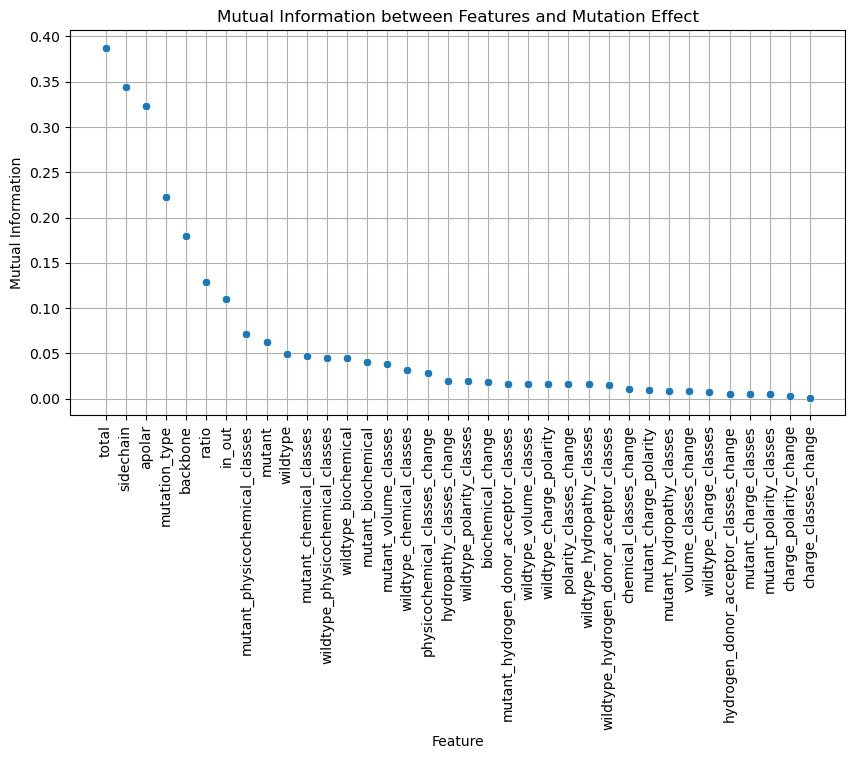

In [50]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=mutual_information, x='feature', y='mutual_information', zorder=2)
plt.title('Mutual Information between Features and Mutation Effect')
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.xticks(rotation=90)
plt.grid(zorder=0)
plt.show()

In [51]:
vespag_scores.columns

Index(['residue', 'mutation', 'vespag', 'id', 'wildtype', 'mutant',
       'mutation_effect', 'mutation_type', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical',
       'mutant_biochemical', 'biochemical_change', 'wildtype_charge_polarity',
       'mutant_charge_polarity', 'charge_polarity_change',
       'wildtype_hydropathy_classes', 'mutant_hydropathy_classes',
       'hydropathy_classes_change', 'wildtype_volume_classes',
       'mutant_volume_classes', 'volume_classes_change',
       'wildtype_chemical_classes', 'mutant_chemical_classes',
       'chemical_classes_change', 'wildtype_physicochemical_classes',
       'mutant_physicochemical_classes', 'physicochemical_classes_change',
       'wildtype_charge_classes', 'mutant_charge_classes',
       'charge_classes_change', 'wildtype_polarity_classes',
       'mutant_polarity_classes', 'polarity_classes_change',
       'wildtype_hydrogen_donor_acceptor_classes',
       'mutant_hydrogen_donor_

In [52]:
vespag_scores.head()

,residue,mutation,vespag,id,wildtype,mutant,mutation_effect,mutation_type,total,apolar,...,physicochemical_classes_change,wildtype_charge_classes,mutant_charge_classes,charge_classes_change,wildtype_polarity_classes,mutant_polarity_classes,polarity_classes_change,wildtype_hydrogen_donor_acceptor_classes,mutant_hydrogen_donor_acceptor_classes,hydrogen_donor_acceptor_classes_change
0,M1,M1A,-2.963631,A0A192B1T2_9HIV1,M,A,0.392495,M-A,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,none,False
1,M1,M1Y,-2.748039,A0A192B1T2_9HIV1,M,Y,0.370785,M-Y,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,polar,True,none,donor and acceptor,True
2,M1,M1W,-2.755614,A0A192B1T2_9HIV1,M,W,0.371548,M-W,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,donor,True
3,M1,M1V,-2.000395,A0A192B1T2_9HIV1,M,V,0.295498,M-V,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,nonpolar,False,none,none,False
4,M1,M1T,-2.908687,A0A192B1T2_9HIV1,M,T,0.386962,M-T,187.69,145.16,...,True,uncharged,uncharged,False,nonpolar,polar,True,none,donor and acceptor,True


In [53]:
vespag_scores['residue_index_zero_based'] = vespag_scores['residue'].str[1:].astype(int) - 1

In [63]:
vespag_scores.id.nunique()

165

In [55]:
annotation_data = ['id', 'residue_index_zero_based', 'wildtype', 'total', 'apolar', 'backbone',
       'sidechain', 'ratio', 'in_out', 'wildtype_biochemical', 'wildtype_charge_polarity',
       'wildtype_hydropathy_classes', 'wildtype_volume_classes',
       'wildtype_chemical_classes', 'wildtype_physicochemical_classes',
       'wildtype_charge_classes', 'wildtype_polarity_classes',
       'wildtype_hydrogen_donor_acceptor_classes']

annotation_df = vespag_scores[annotation_data].drop_duplicates()

# for columns that are floats
for col in ['total', 'apolar', 'backbone', 'sidechain', 'ratio']:
       # normalize the values into [0,1], and then round to the first decimal
       annotation_df[col] = (annotation_df[col] - annotation_df[col].min()) / (annotation_df[col].max() - annotation_df[col].min())
       annotation_df[col] = annotation_df[col].round(1)

annotation_df.to_csv('/mnt/f/nicole/proteingym_166_residue_annotation.csv', sep='\t', index=False)

In [58]:
annotation_df.tail()

,id,residue_index_zero_based,wildtype,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,wildtype_charge_polarity,wildtype_hydropathy_classes,wildtype_volume_classes,wildtype_chemical_classes,wildtype_physicochemical_classes,wildtype_charge_classes,wildtype_polarity_classes,wildtype_hydrogen_donor_acceptor_classes
829825,UBR5_HUMAN,53,M,0.1,0.1,0.0,0.1,0.2,i,hydrophobic,non_polar,hydrophobic,large,sulfur,sulfur,uncharged,nonpolar,none
829844,UBR5_HUMAN,54,E,0.4,0.2,0.1,0.4,0.8,o,negative_charged,negative_charged,hydrophilic,medium,acidic,acidic,negative charged,polar,acceptor
829863,UBR5_HUMAN,55,L,0.5,0.5,0.2,0.4,0.8,o,hydrophobic,non_polar,hydrophobic,large,aliphatic,aliphatic,uncharged,nonpolar,none
829882,UBR5_HUMAN,56,I,0.1,0.1,0.2,0.1,0.1,i,hydrophobic,non_polar,hydrophobic,large,aliphatic,aliphatic,uncharged,nonpolar,none
829901,UBR5_HUMAN,57,I,0.6,0.6,0.4,0.4,0.8,o,hydrophobic,non_polar,hydrophobic,large,aliphatic,aliphatic,uncharged,nonpolar,none


In [66]:
annotation_df.query("id == 'YAP1_HUMAN'")

,id,residue_index_zero_based,wildtype,total,apolar,backbone,sidechain,ratio,in_out,wildtype_biochemical,wildtype_charge_polarity,wildtype_hydropathy_classes,wildtype_volume_classes,wildtype_chemical_classes,wildtype_physicochemical_classes,wildtype_charge_classes,wildtype_polarity_classes,wildtype_hydrogen_donor_acceptor_classes
585466,YAP1_HUMAN,0,M,0.9,0.8,0.6,0.7,1.0,o,hydrophobic,non_polar,hydrophobic,large,sulfur,sulfur,uncharged,nonpolar,none
585485,YAP1_HUMAN,1,D,0.5,0.2,0.2,0.4,1.0,o,negative_charged,negative_charged,hydrophilic,small,acidic,acidic,negative charged,polar,acceptor
585504,YAP1_HUMAN,2,P,0.4,0.4,0.2,0.4,0.9,o,proline,non_polar,neutral,small,aliphatic,P,uncharged,nonpolar,none
585523,YAP1_HUMAN,3,G,0.2,0.1,0.5,0.0,0.8,o,glycine,non_polar,neutral,very small,aliphatic,G,uncharged,nonpolar,none
585542,YAP1_HUMAN,4,Q,0.6,0.2,0.3,0.5,0.9,o,polar_uncharged,polar,hydrophilic,medium,amide,amide,uncharged,polar,donor and acceptor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594947,YAP1_HUMAN,499,F,0.7,0.7,0.3,0.6,0.8,o,hydrophobic,non_polar,hydrophobic,very large,aromatic,F,uncharged,nonpolar,none
594966,YAP1_HUMAN,500,L,0.7,0.7,0.2,0.7,1.0,o,hydrophobic,non_polar,hydrophobic,large,aliphatic,aliphatic,uncharged,nonpolar,none
594985,YAP1_HUMAN,501,T,0.3,0.3,0.2,0.3,0.7,o,polar_uncharged,polar,neutral,small,hydroxyl,hydroxyl,uncharged,polar,donor and acceptor
595004,YAP1_HUMAN,502,W,0.8,0.7,0.3,0.7,0.8,o,hydrophobic,non_polar,hydrophobic,very large,aromatic,W,uncharged,nonpolar,donor


In [64]:
annotation_df.id.nunique()

165